<div align="center"style="font-size:30px;">
MÔ HÌNH RANDOM FOREST VÀ FP-GROWTH
</div>
<div align="center"style="font-size:25px;">
Nhóm: Forever Alone
</div>

## Thư viện

In [16]:
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

from sklearn.model_selection import train_test_split
from sklearn import metrics 
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


ModuleNotFoundError: No module named 'graphviz'

## Chèn dữ liệu

In [17]:
names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital loss','hours-per-week','native-country','result']
df2_train = pd.read_csv('data_adult_income/adult.data', names = names)

names=[ 'age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital loss','hours-per-week','native-country','result']
df2_test = pd.read_csv('data_adult_income/adult.test', names = names)

## Xử lý dữ liệu

In [18]:
main_data = pd.concat([df2_test.assign(ind="df2_test"), df2_train.assign(ind="df2_train")])
main_data.drop(index=main_data.index[0],axis=0,inplace=True)
main_data['workclass'].loc[main_data['workclass'].str.contains('\?')]=' Private'
main_data['occupation'].loc[main_data['occupation'].str.contains('\?')]=' Prof-specialty'
main_data['native-country'].loc[main_data['native-country'].str.contains('\?')]=' United-States'

<>:3: DeprecationWarning: invalid escape sequence \?
<>:4: DeprecationWarning: invalid escape sequence \?
<>:5: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \?
<>:4: DeprecationWarning: invalid escape sequence \?
<>:5: DeprecationWarning: invalid escape sequence \?
C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\119224115.py:3: DeprecationWarning: invalid escape sequence \?
  main_data['workclass'].loc[main_data['workclass'].str.contains('\?')]=' Private'
C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\119224115.py:4: DeprecationWarning: invalid escape sequence \?
  main_data['occupation'].loc[main_data['occupation'].str.contains('\?')]=' Prof-specialty'
C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\119224115.py:5: DeprecationWarning: invalid escape sequence \?
  main_data['native-country'].loc[main_data['native-country'].str.contains('\?')]=' United-States'
C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\119224115.py:3: Setting

In [19]:
df2_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital loss,hours-per-week,native-country,result
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
df2_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital loss', 'hours-per-week', 'native-country',
       'result'],
      dtype='object')

In [21]:
X_train = df2_train.drop(["result"], axis = 1)
y_train = df2_train[["result"]]

X_test = df2_test.drop(["result"], axis = 1)
y_test = df2_test[["result"]]

In [22]:
X_train.shape, y_train.shape

((32561, 14), (32561, 1))

In [23]:
X_test.shape, y_test.shape

((16282, 14), (16282, 1))

In [24]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [25]:
num_cols = X_train.select_dtypes(include = "int64")
cat_cols = X_train.select_dtypes(include = "object")

num_cols.head()

,age,fnlwgt,education-num,capital-gain,capital loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [26]:
cat_cols.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [27]:
print(X_train.isna().mean())
print(X_train.isnull().mean())

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital loss      0.0
hours-per-week    0.0
native-country    0.0
dtype: float64
age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital loss      0.0
hours-per-week    0.0
native-country    0.0
dtype: float64


In [28]:
X_test = X_test.dropna()
print(X_test.isna().mean())
print(X_test.isnull().mean())

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital loss      0.0
hours-per-week    0.0
native-country    0.0
dtype: float64
age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital loss      0.0
hours-per-week    0.0
native-country    0.0
dtype: float64


In [29]:
y_test = y_test.dropna()
print(y_test.isnull().mean())

result    0.0
dtype: float64


In [30]:
print(y_train["result"].unique(), y_test["result"].unique())

[' <=50K' ' >50K'] [' <=50K.' ' >50K.']


In [31]:
y_train = y_train.replace({y_train["result"].unique()[0]: 0, y_train["result"].unique()[1] : 1})
y_test = y_test.replace({y_test["result"].unique()[0]: 0, y_test["result"].unique()[1] : 1})

In [32]:
y_test

,result
1,0
2,0
3,1
4,1
5,0
...,...
16277,0
16278,0
16279,0
16280,0


In [33]:
print(f"The shape of X_train is {X_train.shape}.")
print(f"The shape of X_test is {X_test.shape}.")

X_train_len = len(X_train)
X_test_len = len(X_test)

The shape of X_train is (32561, 14).
The shape of X_test is (16281, 14).


In [34]:
X = pd.concat([X_train,X_test], axis = 0)
print(f"The shape of X is {X.shape}.")

X.head()

The shape of X is (48842, 14).


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital loss,hours-per-week,native-country
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [35]:
#One Hot Encoding
X_new = pd.get_dummies(X, columns = cat_cols.columns)
print(X_new.shape)
X_new.head()

(48842, 108)


,age,fnlwgt,education-num,capital-gain,capital loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516.0,13.0,2174.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311.0,13.0,0.0,0.0,13.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646.0,9.0,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721.0,7.0,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409.0,13.0,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#Recreate X_train and X_test with one hot encoded features
X_train = X_new.iloc[0:X_train_len]
X_test = X_new.iloc[X_train_len:]

print(f"The shape of X_train is {X_train.shape}.")
print(f"The shape of X_test is {X_test.shape}.")

The shape of X_train is (32561, 108).
The shape of X_test is (16281, 108).


In [37]:
#Split into validation/test set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.3, random_state = 1, stratify = y_train)

## Khởi tạo mô hình RandomForest cho phân lớp

In [38]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 0)
rf.fit(X_train, y_train)

C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\1978985527.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=0)

In [39]:
print(f"Accuracy on the training set is {rf.score(X_train,y_train)}.")
print(f"Accuracy on the validation set is {rf.score(X_val,y_val)}.")
print(f"Accuracy on the test set is {rf.score(X_test,y_test)}.")

Accuracy on the training set is 0.999956124956125.
Accuracy on the validation set is 0.8561777049851571.
Accuracy on the test set is 0.8511147963884282.


In [40]:
params = {"n_estimators":range(10,400,50),
         "max_depth":range(5,100,10),
          "criterion":["gini", "entropy"],
          "min_samples_split":range(2,10,2)
         }

random_cv = RandomizedSearchCV(RandomForestClassifier(), params, n_jobs = -1, random_state = 1)

random_cv.fit(X_train,y_train)

c:\Users\tytmm\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(5, 100, 10),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(10, 400, 50)},
                   random_state=1)

In [41]:
random_cv.best_params_

{'n_estimators': 210,
 'min_samples_split': 6,
 'max_depth': 25,
 'criterion': 'entropy'}

In [42]:
rf_best = RandomForestClassifier(min_samples_split = 6, max_depth = 25, criterion = 'gini', n_estimators = 210)
rf_best.fit(X_train,y_train)

C:\Users\tytmm\AppData\Local\Temp\ipykernel_6252\442124747.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best.fit(X_train,y_train)


RandomForestClassifier(max_depth=25, min_samples_split=6, n_estimators=210)

In [43]:
rf_preds = rf_best.predict(X_test)
rf_cm = confusion_matrix(y_test,rf_preds)
print(rf_cm)

rf_precision =precision_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Precision = {}".format(rf_precision))
print("Recall = {}".format(rf_recall))
print("Accuracy = {}".format(rf_accuracy))

[[11732   703]
 [ 1535  2311]]
Precision = 0.7667551426675514
Recall = 0.6008840353614144
Accuracy = 0.8625391560714943


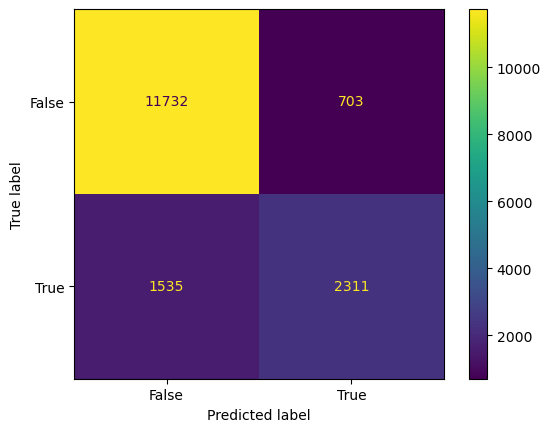

In [44]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [45]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

NameError: name 'graphviz' is not defined

## Khởi tạo FP-Growth cho khai phá luật kết hợp

In [46]:
X.shape

(48842, 14)

In [47]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital loss,hours-per-week,native-country
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [48]:
cat_cols = X.select_dtypes(include = "object")
cat_cols=cat_cols.drop('age',axis=1)
dataset_df = cat_cols.values.tolist()

In [49]:
cat_cols

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
...,...,...,...,...,...,...,...,...
16277,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States
16278,?,HS-grad,Widowed,?,Other-relative,Black,Male,United-States
16279,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
16280,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States


In [50]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset_df).transform(dataset_df)
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [51]:
df = pd.DataFrame(te_ary)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
48838,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
48839,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
48840,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [52]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,?,Adm-clerical,Amer-Indian-Eskimo,...,Transport-moving,Trinadad&Tobago,United-States,Unmarried,Vietnam,White,Widowed,Wife,Without-pay,Yugoslavia
0,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
48838,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
48839,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
48840,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [53]:

frequent_itemsets_fpgrowth=fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets_fpgrowth

,support,itemsets
0,0.897424,( United-States)
1,0.855043,( White)
2,0.668482,( Male)
3,0.329982,( Never-married)
4,0.257627,( Not-in-family)
...,...,...
86,0.299107,"( Female, United-States)"
87,0.266717,"( Female, White)"
88,0.212768,"( Private, Female, United-States)"
89,0.246571,"( Female, United-States, White)"


In [54]:
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.7)
rules_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( United-States),( White),0.897424,0.855043,0.788113,0.878194,1.027076,0.020776,1.190066,0.257004
1,( White),( United-States),0.855043,0.897424,0.788113,0.921723,1.027076,0.020776,1.310420,0.181863
2,( Male),( United-States),0.668482,0.897424,0.598317,0.895038,0.997341,-0.001595,0.977267,-0.007977
3,( Male),( White),0.668482,0.855043,0.588326,0.880092,1.029296,0.016745,1.208902,0.085853
4,"( Male, White)",( United-States),0.588326,0.897424,0.541542,0.920480,1.025691,0.013564,1.289939,0.060843
...,...,...,...,...,...,...,...,...,...,...
269,"( Female, United-States)",( Private),0.299107,0.694198,0.212768,0.711342,1.024697,0.005128,1.059395,0.034387
270,"( Female, United-States)",( White),0.299107,0.855043,0.246571,0.824355,0.964109,-0.009179,0.825284,-0.050434
271,"( Female, White)",( United-States),0.266717,0.897424,0.246571,0.924465,1.030131,0.007212,1.357981,0.039889
272,( Female),"( United-States, White)",0.331518,0.788113,0.246571,0.743762,0.943726,-0.014703,0.826917,-0.081896
